## Chest-X-Rays-Analysis

Identifying Pneumonia in Chest X-Rays by Image-Based Deep Learning

### Import packages

In [6]:
# Import data visualisation and manipulation libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import style
import seaborn as sns
import pprint
import cv2

# Import standard libraries
import os
import random

# File and directory access
from pathlib import Path 
import glob

# Import ML libraries
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configuration of plotting and printing settings 
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
pd.options.display.max_colwidth = 100

# Ignore the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

### Import dataset

Dataset source: https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images

In [7]:
# Path to the data directory
main_path = Path('../Chest-X-Rays-Analysis/data')

# Path to train directory
train_path = main_path / 'train'

# Path to test directory
test_path = main_path / 'test'

# Get the paths to the images in normal and pneumonia sub-directories
train_normal = list((train_path / 'NORMAL').glob('*.jpeg'))
train_pneumonia = list((train_path / "PNEUMONIA").glob('*.jpeg'))
test_normal = list((test_path / 'NORMAL').glob('*.jpeg'))
test_pneumonia = list((test_path / "PNEUMONIA").glob('*.jpeg'))

In [8]:
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , 
                                        ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

In [9]:
df_train

,class,image
0,Normal,..\Chest-X-Rays-Analysis\data\train\NORMAL\_NORMAL-1003233-0001.jpeg
1,Normal,..\Chest-X-Rays-Analysis\data\train\NORMAL\_NORMAL-1012843-0001.jpeg
2,Normal,..\Chest-X-Rays-Analysis\data\train\NORMAL\_NORMAL-1014768-0001.jpeg
3,Normal,..\Chest-X-Rays-Analysis\data\train\NORMAL\_NORMAL-1023731-0001.jpeg
4,Normal,..\Chest-X-Rays-Analysis\data\train\NORMAL\_NORMAL-1029510-0001.jpeg
...,...,...
5227,Pneumonia,..\Chest-X-Rays-Analysis\data\train\PNEUMONIA\_BACTERIA-9975428-0001.jpeg
5228,Pneumonia,..\Chest-X-Rays-Analysis\data\train\PNEUMONIA\_BACTERIA-9988673-0001.jpeg
5229,Pneumonia,..\Chest-X-Rays-Analysis\data\train\PNEUMONIA\_BACTERIA-9988673-0002.jpeg
5230,Pneumonia,..\Chest-X-Rays-Analysis\data\train\PNEUMONIA\_BACTERIA-9988673-0003.jpeg


In [10]:
df_test

,class,image
0,Normal,..\Chest-X-Rays-Analysis\data\test\NORMAL\_NORMAL-1049278-0001.jpeg
1,Normal,..\Chest-X-Rays-Analysis\data\test\NORMAL\_NORMAL-1110860-0001.jpeg
2,Normal,..\Chest-X-Rays-Analysis\data\test\NORMAL\_NORMAL-11419-0001.jpeg
3,Normal,..\Chest-X-Rays-Analysis\data\test\NORMAL\_NORMAL-115218-0001.jpeg
4,Normal,..\Chest-X-Rays-Analysis\data\test\NORMAL\_NORMAL-1160949-0001.jpeg
...,...,...
619,Pneumonia,..\Chest-X-Rays-Analysis\data\test\PNEUMONIA\_BACTERIA-9857270-0003.jpeg
620,Pneumonia,..\Chest-X-Rays-Analysis\data\test\PNEUMONIA\_BACTERIA-9857270-0004.jpeg
621,Pneumonia,..\Chest-X-Rays-Analysis\data\test\PNEUMONIA\_BACTERIA-9913238-0001.jpeg
622,Pneumonia,..\Chest-X-Rays-Analysis\data\test\PNEUMONIA\_BACTERIA-9913238-0002.jpeg


### Data exploration

Dataset consist of two classes: Normal and Pneumonia. 
There are 5232 images in train set and 624 images in test set.

Data distribution in train set:

In [11]:
def plot_distribution_by(data, group, title):
    
    """Function to plot distribution of data in defined groups (count of samples and percentage).
    It takes 3 arguments:
    - data = Pandas DataFrame -> dataset
    - group = Pandas Series -> column to group data by
    - title = String -> name of plot image
    """
    
    plt.figure(figsize=(7,5))

    ax = sns.countplot(x=group, data=data, palette="husl")

    plt.title(title, fontsize=15)
    plt.xlabel("Class", fontsize= 14)
    plt.ylabel("Samples", fontsize= 14)
    plt.ylim(0, (data.groupby(group).count().max()[0] * 1.2))
    plt.xticks(list(range(len(df_train["class"].unique()))), data[group].unique(), fontsize = 13)

    for p in ax.patches:
        ax.annotate((str(p.get_height()) + ", " + str(p.get_height() / len(data) * 100)[0:5] + "%"), 
                    (p.get_x() + 0.25, p.get_height() * 1.05), fontsize = 14)

    plt.show()
    
    return

In [12]:
type(df_train["class"])

pandas.core.series.Series

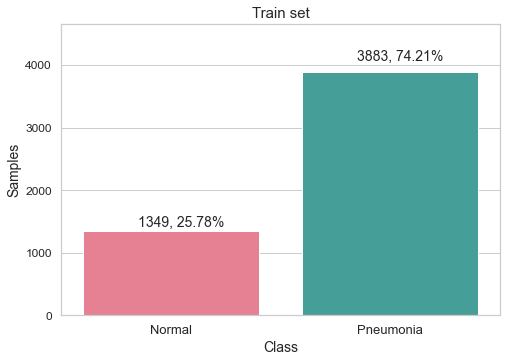

In [13]:
plot_distribution_by(df_train, "class", "Train set")

Data distribution in test set:

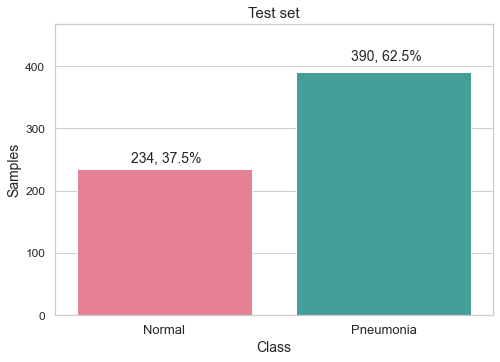

In [14]:
plot_distribution_by(df_test, "class", "Test set")

Both sets seem to be imbalanced having more samples from "Pneumonia" class. Let's see some examples from each set.

In [15]:
IMG_SIZE = 256

In [17]:
def img_print(file_list, path, nrows, ncols):
    
    """Function to print subplots of images from given file list and path.
    It takes 4 arguments:
    - file_list = List -> list of strings with filenames
    - path = WindowsPath (pathlib) => path to folder with images
    - nrows, ncols = Integer -> size of subplot (rows x columns) to be printed
    """
    
    plt.figure(figsize=(10, 10))
    # Counter to iterate over indices of subplot
    i = 1
    
    for file in file_list:
        file_path = path / file
        plt.subplot(nrows, ncols, i)
        # Load image from file
        img = cv2.imread(str(file_path))
        # Resize the image
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        # Display data as an image
        plt.imshow(img)
        # Turn off axis lines and labels
        plt.axis("off")
        # Increment counter
        i = i + 1
    
    plt.tight_layout(w_pad=0.5)
    plt.show()
    
    return

TRAIN DATASET

Printing 6 normal random images

['_NORMAL-4843653-0001.jpeg',
 '_NORMAL-9019297-0002.jpeg',
 '_NORMAL-2239132-0001.jpeg',
 '_NORMAL-7495263-0001.jpeg',
 '_NORMAL-5918516-0002.jpeg',
 '_NORMAL-6727820-0001.jpeg']


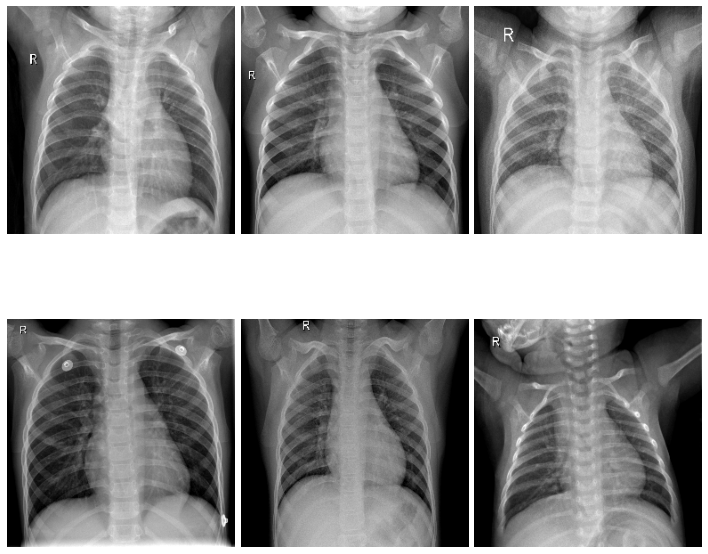


Printing 6 pneumonia random images

['_BACTERIA-4770524-0001.jpeg',
 '_BACTERIA-8446523-0005.jpeg',
 '_BACTERIA-6144621-0003.jpeg',
 '_BACTERIA-3408906-0002.jpeg',
 '_BACTERIA-8660561-0002.jpeg',
 '_BACTERIA-9424776-0003.jpeg']


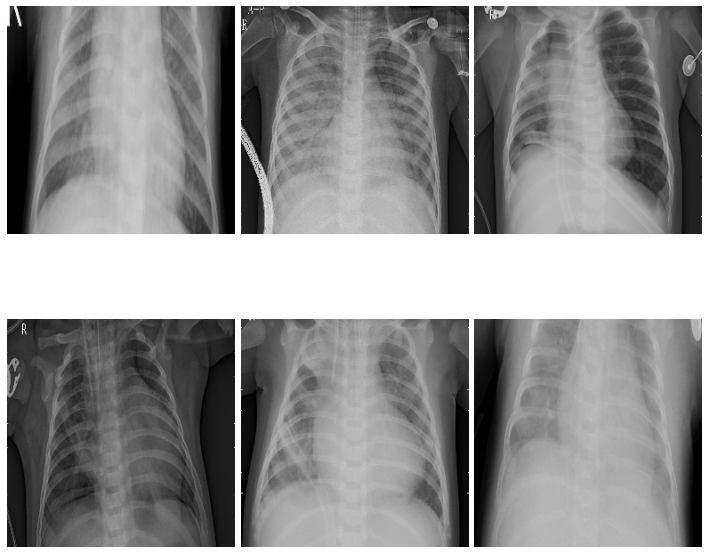


TEST DATASET

Printing 6 normal random images

['_NORMAL-706052-0001.jpeg',
 '_NORMAL-5425295-0001.jpeg',
 '_NORMAL-6569259-0001.jpeg',
 '_NORMAL-2514572-0001.jpeg',
 '_NORMAL-3564811-0001.jpeg',
 '_NORMAL-1931427-0001.jpeg']


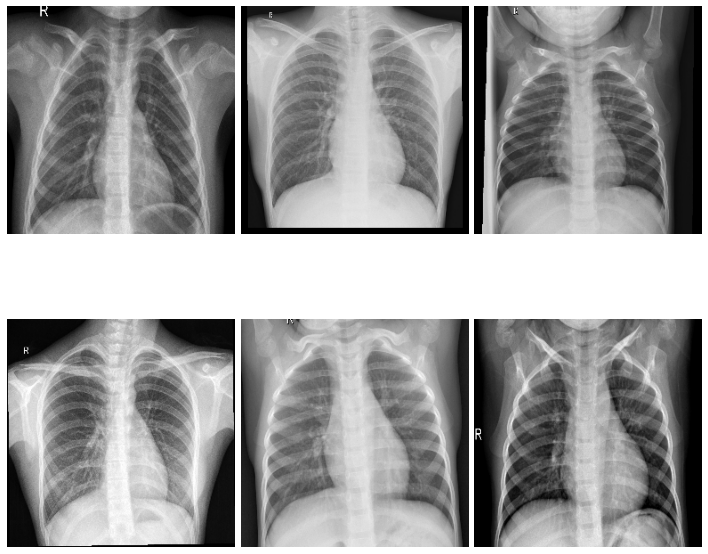


Printing 6 pneumonia random images

['VIRUS-2914571-0001.jpeg',
 '_BACTERIA-7720431-0004.jpeg',
 '_BACTERIA-9242636-0004.jpeg',
 '_BACTERIA-2131702-0001.jpeg',
 '_BACTERIA-5240350-0002.jpeg',
 'VIRUS-1517175-0001.jpeg']


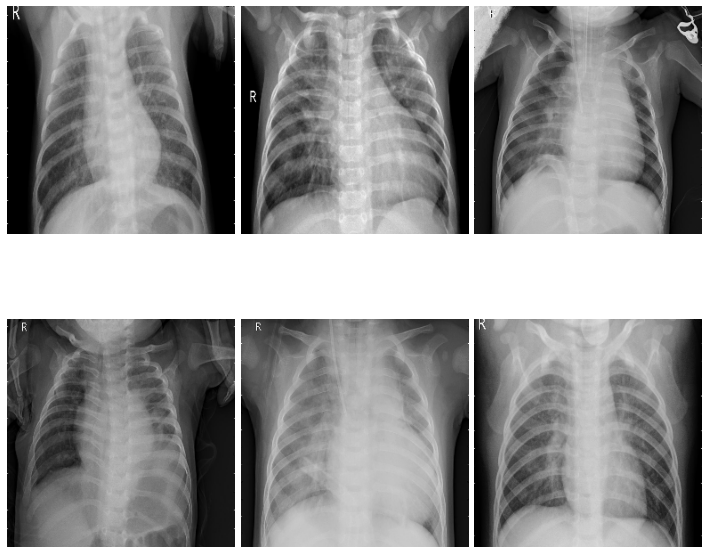

In [18]:
for folder in [train_path, test_path]:
    if folder == train_path:
        print("TRAIN DATASET")
    else:
        print("\nTEST DATASET")
    for subfolder in ["NORMAL", "PNEUMONIA"]:
        path = folder / subfolder
        samples = 6 # number of samples to plot
        random_choices = random.choices(os.listdir(path), k=samples)
        print("\nPrinting " + str(samples) + str.lower(" " + subfolder) + " random images\n")
        pprint.pprint(random_choices)
        img_print(random_choices, path, 2, 3)

### Data preparation

Stratified split on the orginal train dataset is being used to create a validation set. 

In [19]:
SEED = 42

In [20]:
train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = SEED, stratify = df_train['class'])

In [21]:
test_df = df_test

In [22]:
train_df.head()

,class,image
3566,Pneumonia,..\Chest-X-Rays-Analysis\data\train\PNEUMONIA\_BACTERIA-417263-0005.jpeg
2866,Pneumonia,..\Chest-X-Rays-Analysis\data\train\PNEUMONIA\_BACTERIA-1655429-0001.jpeg
2681,Pneumonia,..\Chest-X-Rays-Analysis\data\train\PNEUMONIA\VIRUS-9887625-0003.jpeg
1199,Normal,..\Chest-X-Rays-Analysis\data\train\NORMAL\_NORMAL-9031828-0001.jpeg
4619,Pneumonia,..\Chest-X-Rays-Analysis\data\train\PNEUMONIA\_BACTERIA-783759-0003.jpeg


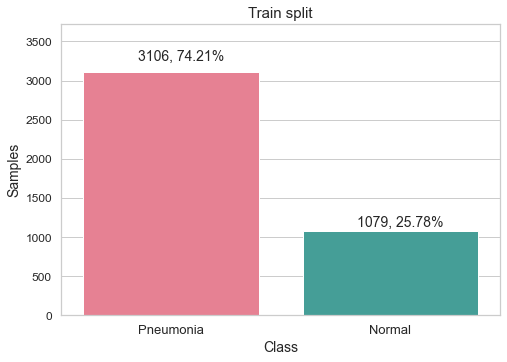

In [23]:
plot_distribution_by(train_df, "class", "Train split")

In [24]:
val_df.head()

,class,image
2945,Pneumonia,..\Chest-X-Rays-Analysis\data\train\PNEUMONIA\_BACTERIA-198200-0004.jpeg
4878,Pneumonia,..\Chest-X-Rays-Analysis\data\train\PNEUMONIA\_BACTERIA-864208-0002.jpeg
3177,Pneumonia,..\Chest-X-Rays-Analysis\data\train\PNEUMONIA\_BACTERIA-2793790-0003.jpeg
972,Normal,..\Chest-X-Rays-Analysis\data\train\NORMAL\_NORMAL-7436212-0002.jpeg
3059,Pneumonia,..\Chest-X-Rays-Analysis\data\train\PNEUMONIA\_BACTERIA-2361522-0001.jpeg


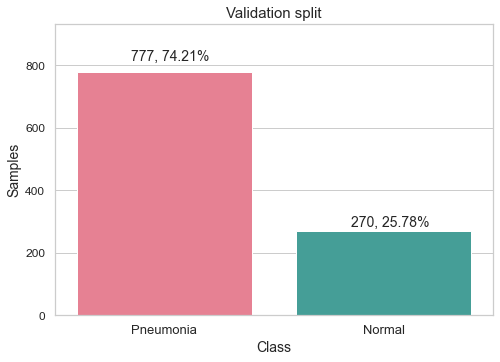

In [25]:
plot_distribution_by(val_df, "class", "Validation split")

I'll use data augmentation to mitigate the problem of having low number of samples in dataset. It won't affect the ratio of positive to negative cases. It may help the model to tackle the imbalance problem by presenting it larger number of cases so it can find the patter more easily. 
All of the images will be resized. For data augmentation I'll consider only rotate and zoom operations. Other modifications like shearing, flipping or changing brightness and contrast level could cause that representation of dataset would be not true anymore. 

In [26]:
train_df["image"] = train_df["image"].astype(str)
val_df["image"] = val_df["image"].astype(str)
test_df["image"] = test_df["image"].astype(str)

I am using Keras ImageDataGenrator for data augmentation on the fly. Image transformations will be performed while training the model. 

In [27]:
BATCH = 32

In [28]:
train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,
                                  rotation_range = 0.1)


val_datagen = ImageDataGenerator(rescale=1/255.)

In [29]:
ds_train = train_datagen.flow_from_dataframe(train_df,
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             seed = 42,
                                             batch = BATCH)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                        x_col = 'image',
                                        y_col = 'class',
                                        target_size = (IMG_SIZE, IMG_SIZE),
                                        class_mode = 'binary',
                                        seed = 42, 
                                        batch = BATCH)

ds_test = val_datagen.flow_from_dataframe(df_test,
                                          x_col = 'image',
                                          y_col = 'class',
                                          target_size = (IMG_SIZE, IMG_SIZE),
                                          class_mode = 'binary',
                                          batch_size = 1,
                                          shuffle = False)

Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


### Convolutional Neural Network

First I am setting callbacks to perform different actions while monitoring the learning process. EarlyStopping will stop training when a monitored metric has stopped improving and ReduceLROnPlateau will reduce learning rate when a metric has stopped improving.

In [30]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
    verbose=1
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 1e-7,                                
    cooldown = 0,                               
    verbose = 1
) 

Defining the model by adding layers:

In [31]:
def get_model():
    
    # Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Block One
    x = layers.Conv2D(filters=16, kernel_size=3, padding='valid')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)

    # Block Two
    x = layers.Conv2D(filters=32, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)
    
    # Block Three
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.4)(x)

    # Top Layers
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

Since the classification problem contains only two categories I am using binary crossentropy as a loss function. 

In [55]:
# To avoid clutter from old models and layers
keras.backend.clear_session()

model = get_model()
model.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=3e-5), metrics='binary_accuracy')

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 254, 254, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 16)      0     

In [56]:
history = model.fit(ds_train,
          batch_size = BATCH, epochs = 50,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/50
130/130 [==============================] - 231s 2s/step - loss: 0.4204 - binary_accuracy: 0.8215 - val_loss: 0.9736 - val_binary_accuracy: 0.7421 - lr: 3.0000e-05
Epoch 2/50
130/130 [==============================] - 183s 1s/step - loss: 0.2292 - binary_accuracy: 0.9075 - val_loss: 1.5869 - val_binary_accuracy: 0.7421 - lr: 3.0000e-05
Epoch 3/50
130/130 [==============================] - 184s 1s/step - loss: 0.1561 - binary_accuracy: 0.9381 - val_loss: 1.1437 - val_binary_accuracy: 0.7421 - lr: 6.0000e-06
Epoch 5/50
130/130 [==============================] - 185s 1s/step - loss: 0.1505 - binary_accuracy: 0.9453 - val_loss: 0.4835 - val_binary_accuracy: 0.8080 - lr: 6.0000e-06
Epoch 6/50
130/130 [==============================] - 186s 1s/step - loss: 0.1457 - binary_accuracy: 0.9446 - val_loss: 0.2370 - val_binary_accuracy: 0.8997 - lr: 6.0000e-06
Epoch 7/50
130/130 [==============================] - 188s 1s/step - loss: 0.1497 - binary_accuracy: 0.9429 - val_loss: 0.1819 - v

In [61]:
model.save('models/model_1')

INFO:tensorflow:Assets written to: models/model_1\assets


INFO:tensorflow:Assets written to: models/model_1\assets


Let's plot loss changes during the learning process for train and validation datasets.

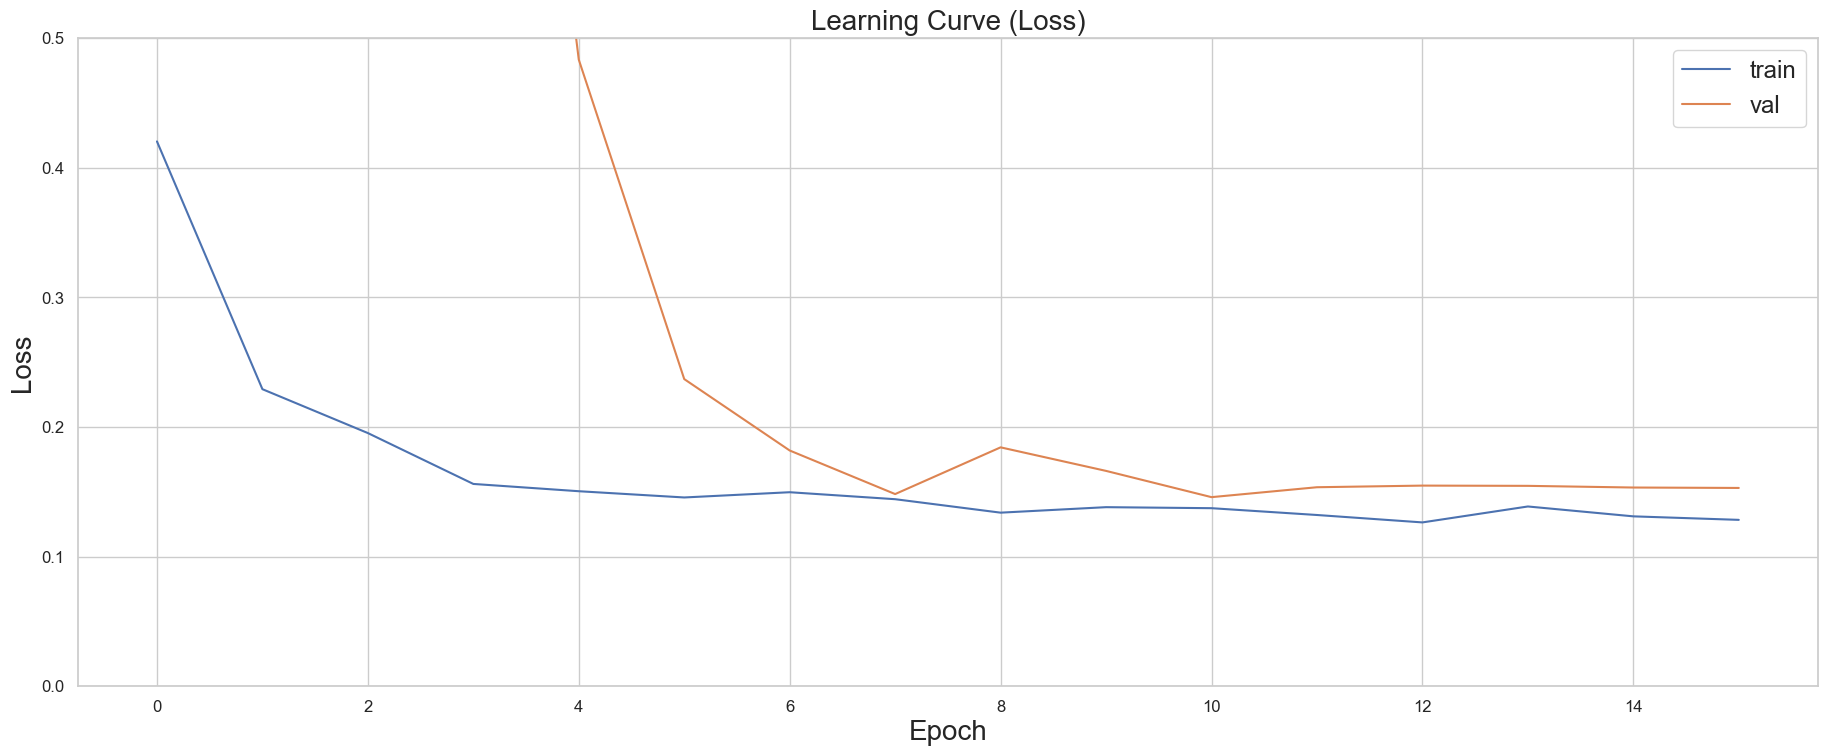

In [96]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)', fontsize=20)
ax.set_ylabel('Loss', fontsize=20)
ax.set_xlabel('Epoch', fontsize=20)
ax.set_ylim(0, 0.5)
ax.legend(['train', 'val'], loc='best', fontsize='x-large')
plt.show()

Let's plot accuracy changes during the learning process for train and validation datasets.

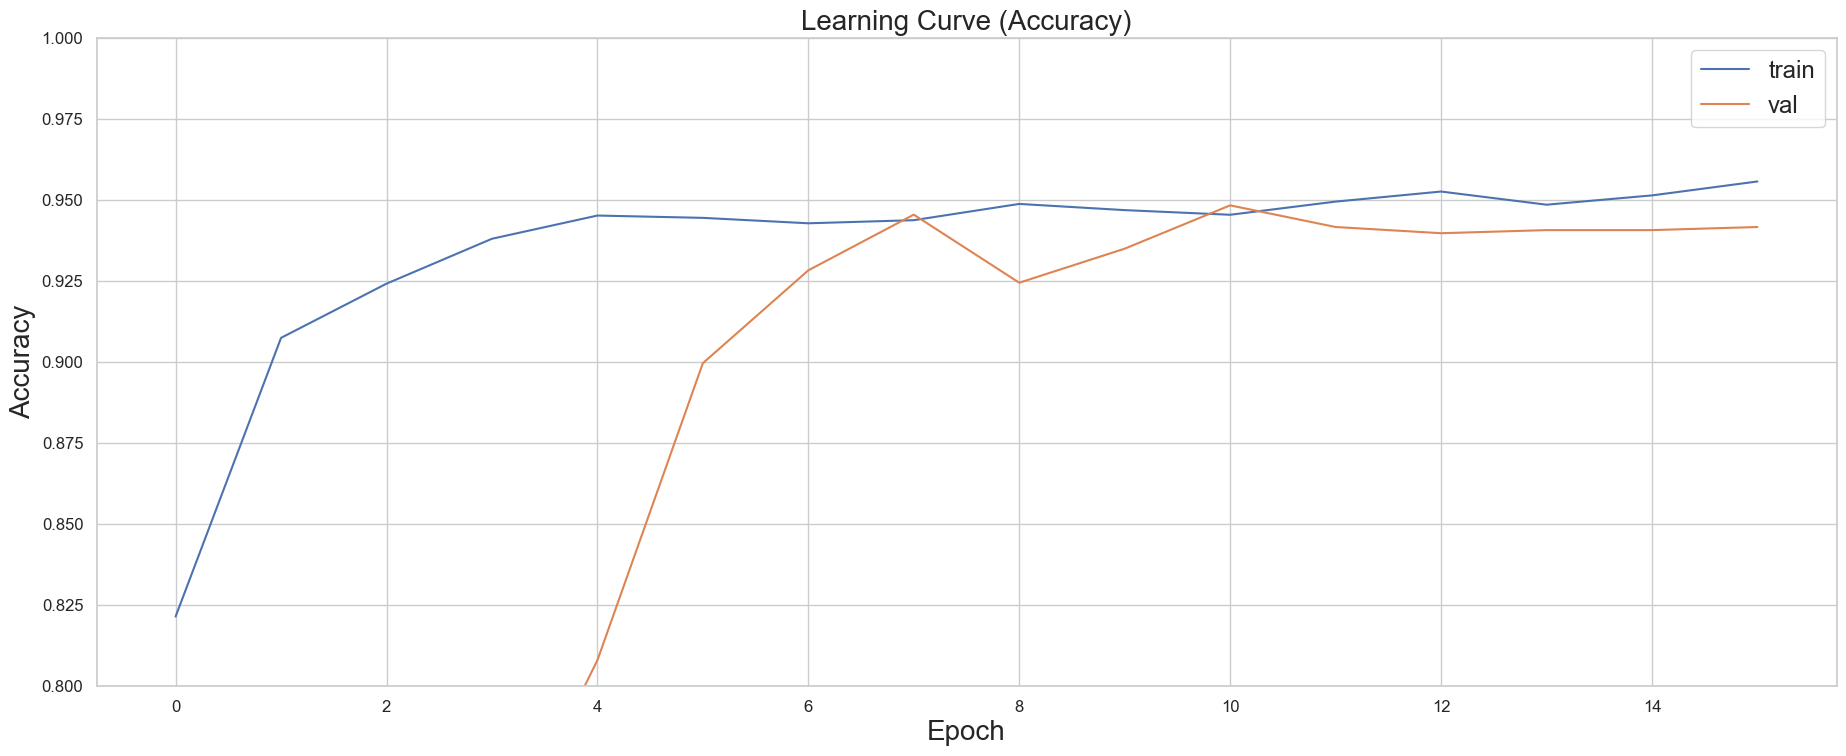

In [98]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)', fontsize=20)
ax.set_ylabel('Accuracy', fontsize=20)
ax.set_xlabel('Epoch', fontsize=20)
ax.set_ylim(0.80, 1.0)
ax.legend(['train', 'val'], loc='best', fontsize='x-large')
plt.show()

Let's evaluate the model and print loss and accuracy for validation and test datasets:

In [99]:
score = model.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.145908921957016
Val accuracy: 0.9484240412712097


In [100]:
score = model.evaluate(ds_test, steps = len(df_test), verbose = 0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6001783013343811
Test accuracy: 0.7916666865348816


Final score is not satisfying. Let's try building another model. 

In [32]:
def get_model():
    
    # Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Block One
    x = layers.Conv2D(32,(3,3))(inputs)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(pool_size=(2,2))(x)
    
    # Block Two
    x = layers.Conv2D(32,(3,3))(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(pool_size=(2,2))(x)
    
    # Block Three
    x = layers.Conv2D(64,(3,3))(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(pool_size=(2,2))(x)
    
    # Top Layers
    x = layers.Flatten()(x)
    x = layers.Dense(64)(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [110]:
# To avoid clutter from old models and layers
keras.backend.clear_session()

model = get_model()
model.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=3e-5), metrics='binary_accuracy')

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 activation (Activation)     (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 125, 125, 32)      0         
                                                             

In [111]:
history = model.fit(ds_train,
          batch_size = BATCH, epochs = 50,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/50
130/130 [==============================] - 224s 2s/step - loss: 0.5328 - binary_accuracy: 0.7460 - val_loss: 0.4401 - val_binary_accuracy: 0.7803 - lr: 3.0000e-05
Epoch 2/50
130/130 [==============================] - 199s 2s/step - loss: 0.3644 - binary_accuracy: 0.8528 - val_loss: 0.2805 - val_binary_accuracy: 0.9160 - lr: 3.0000e-05
Epoch 3/50
130/130 [==============================] - 180s 1s/step - loss: 0.2580 - binary_accuracy: 0.8977 - val_loss: 0.2130 - val_binary_accuracy: 0.9303 - lr: 3.0000e-05
Epoch 4/50
130/130 [==============================] - 198s 2s/step - loss: 0.2221 - binary_accuracy: 0.9168 - val_loss: 0.1644 - val_binary_accuracy: 0.9389 - lr: 3.0000e-05
Epoch 5/50
130/130 [==============================] - 190s 1s/step - loss: 0.1971 - binary_accuracy: 0.9223 - val_loss: 0.1656 - val_binary_accuracy: 0.9379 - lr: 3.0000e-05
Epoch 6/50
130/130 [==============================] - 176s 1s/step - loss: 0.1743 - binary_accuracy: 0.9372 - val_loss: 0.1330 - v

In [112]:
model.save('models/model_2')

INFO:tensorflow:Assets written to: models/model_2\assets


INFO:tensorflow:Assets written to: models/model_2\assets


Let's plot loss changes during the learning process for train and validation datasets.

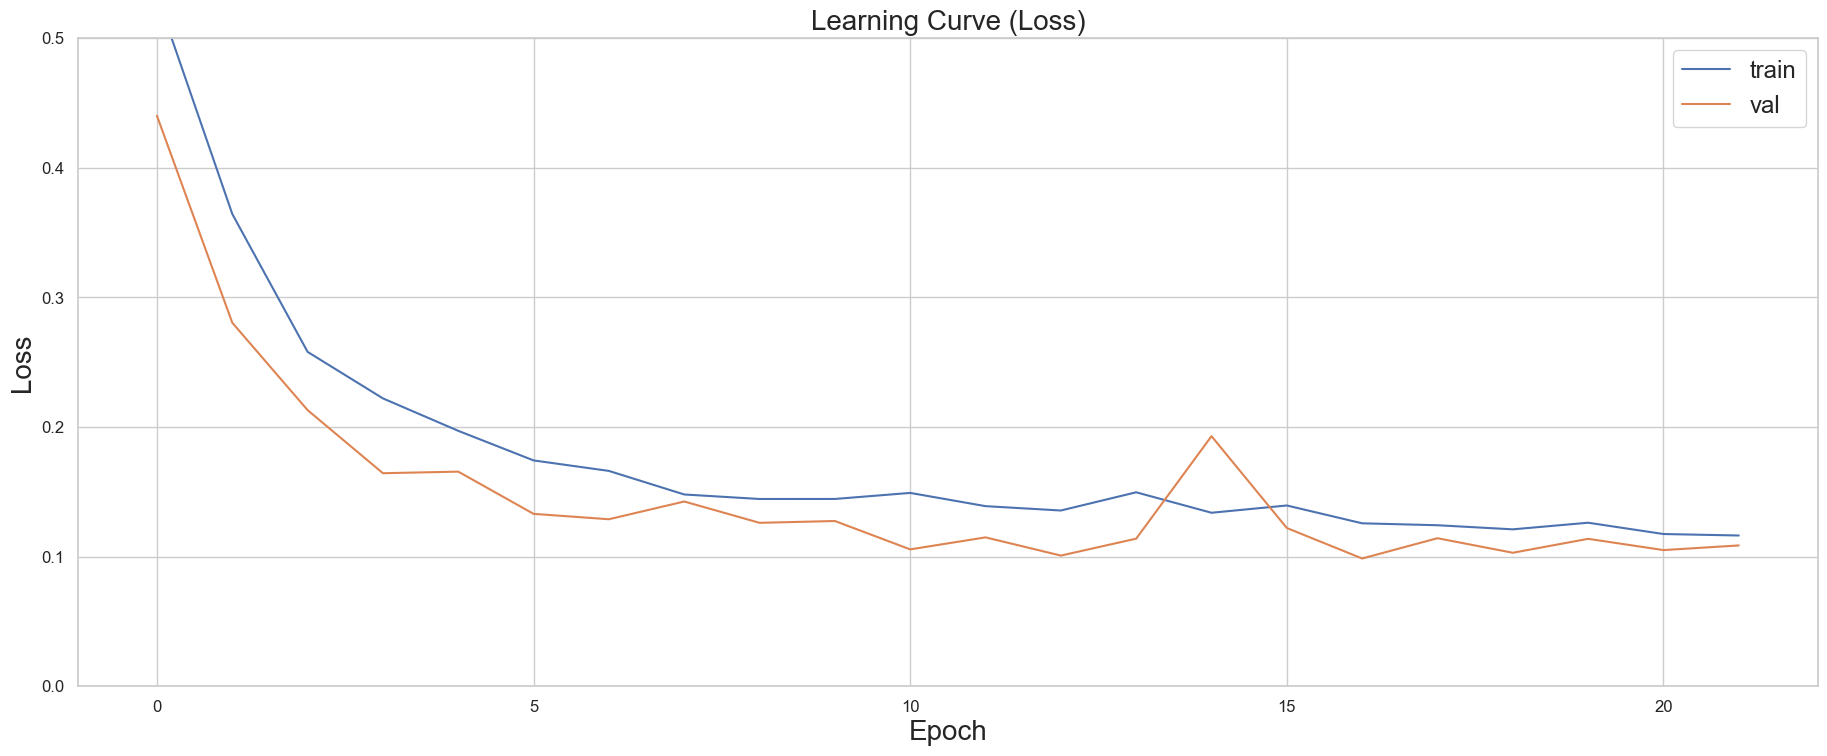

In [114]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)', fontsize=20)
ax.set_ylabel('Loss', fontsize=20)
ax.set_xlabel('Epoch', fontsize=20)
ax.set_ylim(0, 0.5)
ax.legend(['train', 'val'], loc='best', fontsize='x-large')
plt.show()

Let's plot accuracy changes during the learning process for train and validation datasets.

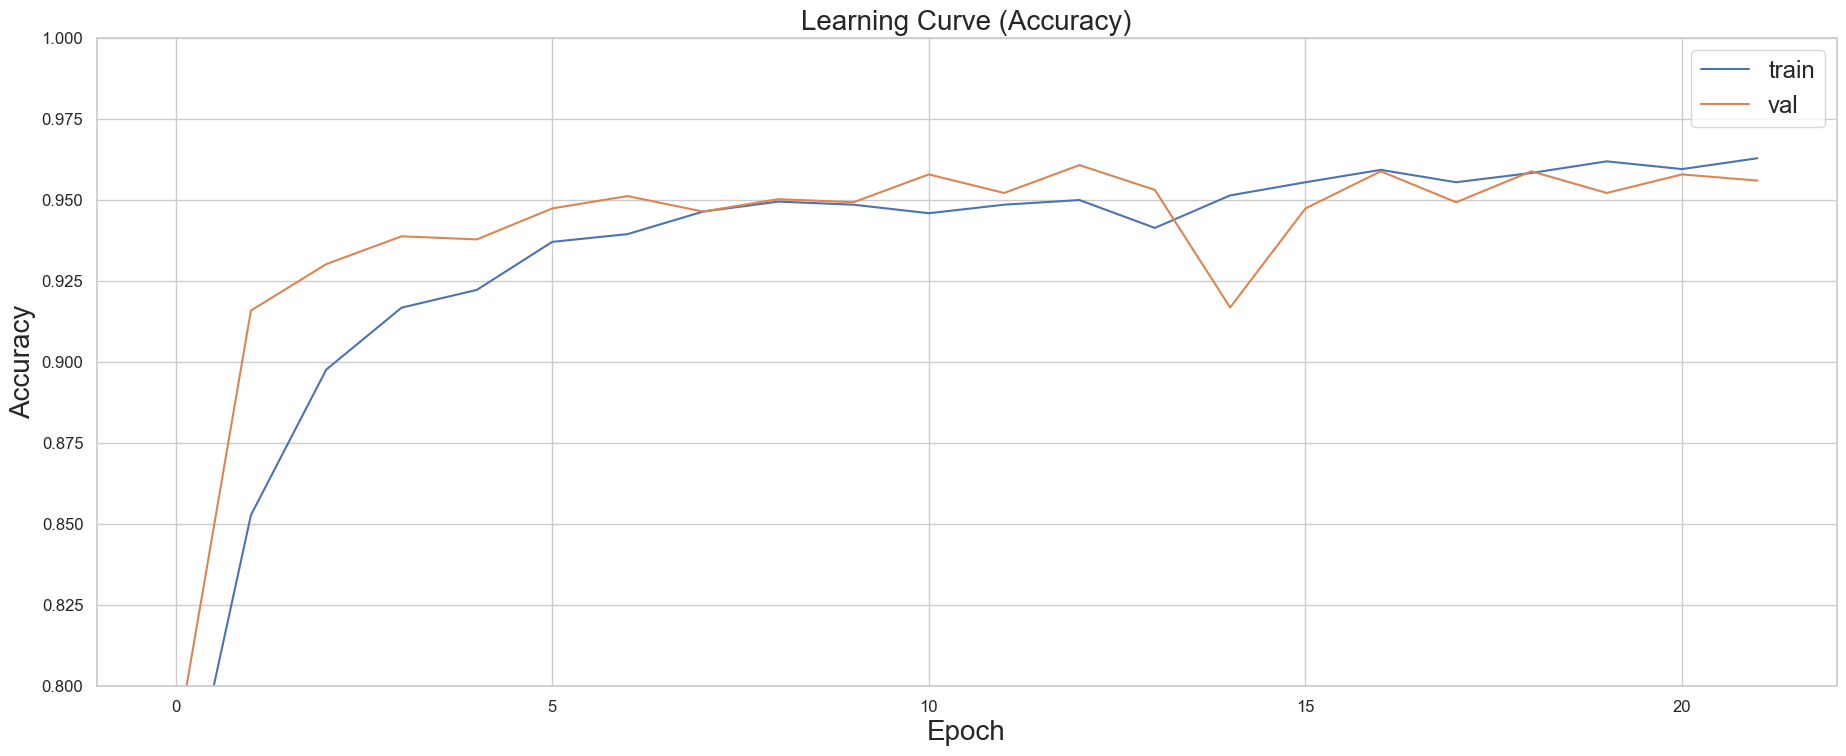

In [115]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)', fontsize=20)
ax.set_ylabel('Accuracy', fontsize=20)
ax.set_xlabel('Epoch', fontsize=20)
ax.set_ylim(0.80, 1.0)
ax.legend(['train', 'val'], loc='best', fontsize='x-large')
plt.show()

Let's evaluate the model and print loss and accuracy for validation and test datasets:

In [116]:
score = model.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.09857961535453796
Val accuracy: 0.958930253982544


In [117]:
score = model.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.3247058391571045
Test accuracy: 0.9038461446762085


This model seems to perform much better than the first one. Let's check performance metrics.

In [38]:
num_label = {'Normal': 0, 'Pneumonia' : 1}
Y_test = df_test['class'].copy().map(num_label).astype('int')

In [41]:
ds_test.reset()
predictions = model.predict(ds_test, steps=len(ds_test), verbose=0)
pred_labels= np.where(predictions>0.5, 1, 0)

In [43]:
print("Test Accuracy: ", accuracy_score(Y_test, pred_labels))

Test Accuracy:  0.9038461538461539


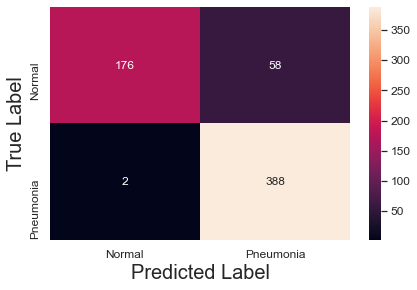

In [91]:
confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels)
sns.heatmap(confusion_matrix, annot=True, fmt="d", xticklabels = num_label, yticklabels = num_label)
plt.xlabel("Predicted Label", fontsize= 20)
plt.ylabel("True Label", fontsize= 20)
plt.show()

In [57]:
print(metrics.classification_report(Y_test, pred_labels, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.99      0.75      0.85       234
           1       0.87      0.99      0.93       390

    accuracy                           0.90       624
   macro avg       0.93      0.87      0.89       624
weighted avg       0.91      0.90      0.90       624



ROC_AUC:  0.9797446855139162


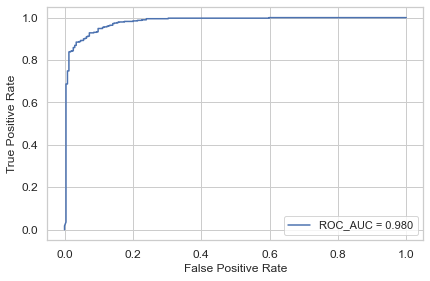

In [64]:
roc_auc = metrics.roc_auc_score(Y_test, predictions)
print('ROC_AUC: ', roc_auc)

fpr, tpr, thresholds = metrics.roc_curve(Y_test, predictions)

plt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

// DESCRIBE 

The recall was close to 100%. Even without expertise on the medical field, it’s reasonable to assume that false negatives are more ‘costly’ than false positives in this case. Reaching such recall with a relatively small dataset for training as this one, while also reaching a pretty good recall, is a good indicative of the model’s capabilities. Such capabilities are also confirmed by the high ROC-AUC value.

https://www.kaggle.com/code/faressayah/chest-x-ray-medical-diagnosis-with-deep-learning

dodać transfer learning

https://github.com/trangiabach/Lung-Iris

### TODO

0) Check image sizes https://www.kaggle.com/code/suvoooo/detectpneumonia-inceptionresnetv2-class-imbalance/notebook
1) Fix data imbalances after buidling first model
2) Change subplot to subplots function in data exploration part
3) Change the way the dataset is being augmented
4) Add saving history https://stackoverflow.com/questions/41061457/keras-how-to-save-the-training-history-attribute-of-the-history-object